# Gamma spec analysis

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gs_analysis as ga

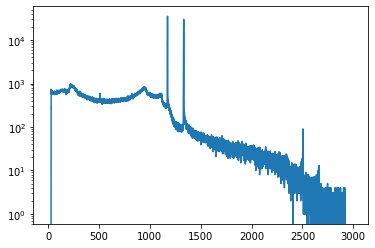

In [4]:
path = "test_data/Co_60_raised_1.spe"
counts, ebins = ga.get_spect(path)

ga.plot_spec(counts, erg=ebins)

### Peak finder
- Mariscotti/Routti
- Scipy